In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
X_train= X_train.reshape(-1,784)
X_test= X_test.reshape(-1,784)
X_train=X_train/255.
X_test=X_test/255.

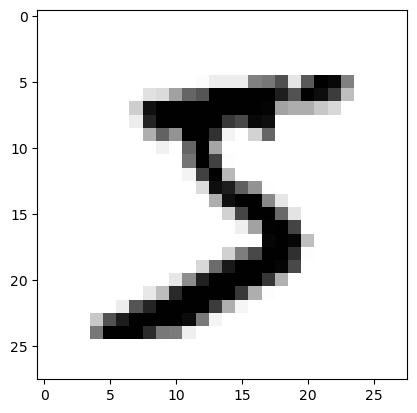

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.imshow(X_train[0].reshape(28,28),cmap=cm.gray_r)
plt.show()

In [4]:
import torch
# 학습용 데이터 텐서 변환
# from_numpy() 넘파이배열을 텐서로 변환
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.astype('int32')).long()
# 검증용 데이터 텐서 변환
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.astype('int32')).long()
# 변환된 텐서의 샘플수 확인
print(X_train.shape)
print(y_train.shape)

torch.Size([60000, 784])
torch.Size([60000])


In [5]:
X_train=X_train.cuda()
y_train=y_train.cuda()
X_test=X_test.cuda()
y_test=y_test.cuda()

In [6]:
from torch.utils.data import DataLoader, TensorDataset
# 독립변수와 종속변수 텐서를 합침
train = TensorDataset(X_train, y_train)
# 미니배치 분할
train_loader = DataLoader(train, batch_size=100, shuffle=True)

In [12]:
import torch.nn as nn
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=0)
    
model = Net().cuda()

In [8]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
# 손실함수
criterion = nn.CrossEntropyLoss()
# 최적화함수
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    total_loss = 0
    for X_train, y_train in train_loader:
        # 계산 그래프 구성
        X_train, y_train = Variable(X_train), Variable(y_train)
        X_train=X_train.cuda()
        y_train=y_train.cuda()
        # 경사 초기화
        optimizer.zero_grad()
        # 순전파 계산
        output = model(X_train)
        # 오차계산
        loss = criterion(output, y_train)
        # 역전파 계산
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 누적 오차 계산
        total_loss += loss.data
    # 10회 반복마다 누적오차 출력
    if (epoch+1) % 10 == 0:
        print(epoch+1, total_loss)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_15196\1610418841.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


10 tensor(261.3610, device='cuda:0')
20 tensor(78.1282, device='cuda:0')
30 tensor(38.2566, device='cuda:0')
40 tensor(18.7830, device='cuda:0')
50 tensor(8.2904, device='cuda:0')
60 tensor(3.8923, device='cuda:0')
70 tensor(1.6902, device='cuda:0')
80 tensor(0.9981, device='cuda:0')
90 tensor(0.6509, device='cuda:0')
100 tensor(0.4349, device='cuda:0')


In [9]:
# 계산 그래프 구성
X_test, y_test = Variable(X_test), Variable(y_test)
result = torch.max(model(X_test).data, 1)[1]
y_test=y_test.cpu()
result=result.cpu()
print(result[:5]) # 출력값
print(y_test.data.numpy()[:5]) #실제값
# 모형의 정확도 측정
accuracy = sum(y_test.data.numpy() == result.numpy()) / len(y_test.data.numpy())
# 모형의 정확도 출력
accuracy

tensor([7, 2, 1, 0, 4])
[7 2 1 0 4]


C:\Users\tjoeun\AppData\Local\Temp\ipykernel_15196\1610418841.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0.972

In [10]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
from torchinfo import summary
batch_size=100
# batch_size, channels, height, width
summary(model, input_size=(batch_size, 784))

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_15196\1610418841.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 256]                200,960
├─Linear: 1-2                            [100, 256]                65,792
├─Linear: 1-3                            [100, 256]                65,792
├─Linear: 1-4                            [100, 128]                32,896
├─Linear: 1-5                            [100, 128]                16,512
├─Linear: 1-6                            [100, 10]                 1,290
Total params: 383,242
Trainable params: 383,242
Non-trainable params: 0
Total mult-adds (M): 38.32
Input size (MB): 0.31
Forward/backward pass size (MB): 0.83
Params size (MB): 1.53
Estimated Total Size (MB): 2.67